## Imports

In [58]:
# Determine quality from other traits
# Cluster and determine wine type

import pandas as pd
from pandas import DataFrame, Series
from patsy import dmatrices
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import tree
import statsmodels.api as sm
import os

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# OLS Regression

Determining wine quality from all other factors

## Setup

Assemble the red and white dataframes, then concatenate them into a master dataframe.

In [59]:
# Load red wines
names = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'color']

dfRed = pd.read_csv('data/winequality-red.csv', sep=";")
dfRed['color'] = 'red'
dfRed.columns = names

# Load white wines
dfWhite = pd.read_csv('data/winequality-white.csv', sep=";")
dfWhite['color'] = 'white'
dfWhite.columns = names

# Create master dataframe
df = pd.concat([dfRed, dfWhite])
df = df.reset_index(drop=True)

df[:5]

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,red


Create formula for the quality of a wine from all other variables

In [60]:
# Exclude color (categorical) and quality from regressing on quality
traitsToExclude = ['color', 'quality']

# Generate formula
initialFormula = 'quality ~ 0 + ' + " + ".join([column for column in df if column not in traitsToExclude])
initialFormula

'quality ~ 0 + fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + pH + sulphates + alcohol'

## Red Wines

Run regression on red wines

In [61]:
def ols(data, formula):
    # Load inital design matrix
    y, X = dmatrices(formula, data=data, return_type='dataframe')

    # Fit initial model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    model = sm.OLS(y_train, X_train)
    result = model.fit()
    return result

result = ols(dfRed, initialFormula)
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     7731.
Date:                Sun, 30 Apr 2017   Prob (F-statistic):               0.00
Time:                        15:03:03   Log-Likelihood:                -1102.4
No. Observations:                1119   AIC:                             2227.
Df Residuals:                    1108   BIC:                             2282.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed_acidity            0.0107 

In [62]:
# Looks great! But we can do better
# Create new formula and fit new design matrix
exemptions = ['color', 'quality', 'fixed_acidity', 'citric_acid', 'residual_sugar', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'pH', 'chlorides']
newFormula = 'quality ~ 0 + ' + " + ".join([column for column in df if column not in exemptions])
result = ols(dfRed, newFormula)
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 2.045e+04
Date:                Sun, 30 Apr 2017   Prob (F-statistic):               0.00
Time:                        15:03:03   Log-Likelihood:                -1127.5
No. Observations:                1119   AIC:                             2263.
Df Residuals:                    1115   BIC:                             2283.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
volatile_acidity    -1.2977      0.118  

In [63]:
# Looks great!
result.params

volatile_acidity   -1.297727
density             2.665419
sulphates           0.631601
alcohol             0.313136
dtype: float64

## White Wines

In [64]:
# Recreate master formula
traitsToExclude = ['color', 'quality']
initialFormula = 'quality ~ 0 + ' + " + ".join([column for column in df if column not in traitsToExclude])

result = ols(dfWhite, initialFormula)
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.983
Method:                 Least Squares   F-statistic:                 1.853e+04
Date:                Sun, 30 Apr 2017   Prob (F-statistic):               0.00
Time:                        15:03:04   Log-Likelihood:                -3933.1
No. Observations:                3428   AIC:                             7888.
Df Residuals:                    3417   BIC:                             7956.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
fixed_acidity           -0.0547 

In [65]:
# Optimize result
traitsToExclude = ['color', 'quality', 'volatile_acidity', 'citric_acid', 'chlorides', 'density', 'pH' ,'sulphates', 'total_sulfur_dioxide']
newFormula = 'quality ~ 0 + ' + " + ".join([column for column in df if column not in traitsToExclude])
result = ols(dfWhite, newFormula)
print result.summary()

                            OLS Regression Results                            
Dep. Variable:                quality   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 4.536e+04
Date:                Sun, 30 Apr 2017   Prob (F-statistic):               0.00
Time:                        15:03:04   Log-Likelihood:                -4132.6
No. Observations:                3428   AIC:                             8273.
Df Residuals:                    3424   BIC:                             8298.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
fixed_acidity           0.0548    

In [66]:
result.params

fixed_acidity          0.054813
residual_sugar         0.030799
free_sulfur_dioxide    0.007426
alcohol                0.478847
dtype: float64

# Logistic Regression

In [67]:
# Determine color from other traits

# Create formula to identify color
formula = "color ~ 0 + " + " + ".join([column for column in df if column != 'color'])
formula

'color ~ 0 + fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + pH + sulphates + alcohol + quality'

In [68]:
# Split up design matrices
Y, X = dmatrices(formula, data=df, return_type="dataframe")
# Since color is a binary categorical variable, we can look just for red
y = Y['color[red]'].values

# Split into test data and fit model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
model = LogisticRegression()
result = model.fit(X_train, y_train)

In [69]:
# Score model - nice!
prediction = model.predict(X_test)
metrics.accuracy_score(y_test, prediction)

0.97692307692307689

In [70]:
# What's important?
weights = Series(model.coef_[0], index=X.columns.values)
weights.sort_values()

density                -2.315548
citric_acid            -0.857329
alcohol                -0.749802
quality                -0.189379
residual_sugar         -0.146161
total_sulfur_dioxide   -0.064951
free_sulfur_dioxide     0.045673
fixed_acidity           0.685058
pH                      1.919069
chlorides               2.019862
sulphates               6.924902
volatile_acidity        8.142736
dtype: float64

In [71]:
# Can we make a chart to figure out how great a wine is?
traitsToExclude = ['color', 'quality']
formula = 'C(quality) ~ 0 + C(color) + ' + " + ".join([column for column in df if column not in traitsToExclude])
formula

'C(quality) ~ 0 + C(color) + fixed_acidity + volatile_acidity + citric_acid + residual_sugar + chlorides + free_sulfur_dioxide + total_sulfur_dioxide + density + pH + sulphates + alcohol'

array([6, 5, 7, 8, 4, 3, 9])

{3: 0.9916666666666667, 4: 0.93541666666666667, 5: 0.68333333333333335, 6: 0.67083333333333328, 7: 0.88124999999999998, 8: 0.98333333333333328}
{3: 0.9938775510204082, 4: 0.94965986394557822, 5: 0.76598639455782314, 6: 0.66938775510204085, 7: 0.81564625850340133, 8: 0.94897959183673475, 9: 1.0}


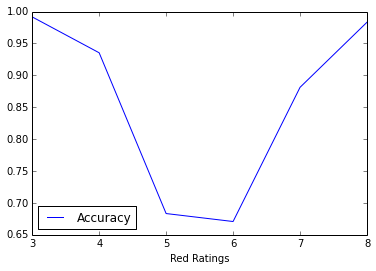

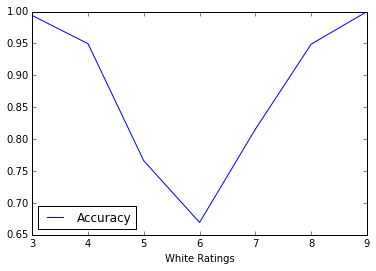

In [82]:
for idf in [dfRed, dfWhite]:
    nums = {}
    ratings = idf.quality.unique()
    for num in ratings:
        Y, X = dmatrices(formula, idf, return_type='dataframe')
        y = Y["C(quality)[%d]" % num].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
        model = tree.DecisionTreeClassifier(criterion='entropy')
        result = model.fit(X_train, y_train)
        prediction = model.predict(X_test)
        nums[num] = metrics.accuracy_score(y_test, prediction)
    print nums
    numdf = DataFrame(nums.items(), columns=["Rating", "Accuracy"])
    numdf.plot(x="Rating", y="Accuracy").set_xlabel("%s Ratings" % idf.color.unique()[0].title())

In [ ]:
tree.export_graphviz(model, feature_names=X.columns)
os.system('dot -Tpng tree.dot -o tree.png')

![9](tree.png)

In [83]:
print "Red Qualities"
print dfRed['quality'].value_counts()
print ""
print "White Qualities"
print dfWhite['quality'].value_counts()

Red Qualities
5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

White Qualities
6    2198
5    1457
7     880
8     175
4     163
3      20
9       5
Name: quality, dtype: int64
